## 安排数据集

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Files already downloaded and verified


展示一些训练数据的图片

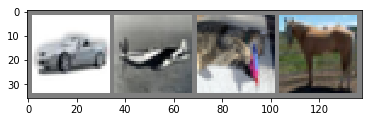

  car plane   cat horse


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机得到一些训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 定义模型

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3层的图片，RGB ， 这里的 6 就成了输出的厚度
        self.pool = nn.MaxPool2d(2, 2) # 这个操作可以重复用
        self.conv2 = nn.Conv2d(6, 16, 5) # 再来另一个卷基层 ，上一层里面，厚度3 变6，这里6 就是输入 （？）
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # 拉成1维向量
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 损失函数和优化器

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 训练

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.176
[1,  4000] loss: 1.853
[1,  6000] loss: 1.670
[1,  8000] loss: 1.565
[1, 10000] loss: 1.508
[1, 12000] loss: 1.462
[2,  2000] loss: 1.401
[2,  4000] loss: 1.367
[2,  6000] loss: 1.336
[2,  8000] loss: 1.299
[2, 10000] loss: 1.295
[2, 12000] loss: 1.286
Finished Training


## 测试网络准确率

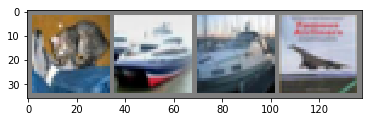

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:

outputs = net(images)
# one hot -> label 
_, predicted = torch.max(outputs, 1) 
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


## 整个数据集上的表现

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 66 %
Accuracy of  bird : 22 %
Accuracy of   cat : 25 %
Accuracy of  deer : 58 %
Accuracy of   dog : 63 %
Accuracy of  frog : 54 %
Accuracy of horse : 71 %
Accuracy of  ship : 77 %
Accuracy of truck : 65 %


还行